In [1]:
import math
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, uniform, chi2
import numpy as np
from scipy.stats.mstats import gmean
from numpy.testing import assert_allclose
from iteround import saferound
from utils import sprt_mart, alpha_mart, shrink_trunc, stratum_selector, \
    multinomial_selector, get_global_pvalue, simulate_audits, round_robin, ucb_selector
np.random.seed(123456789)

In [2]:
N = np.array([100, 100]) #stratum sizes
w = N / np.sum(N)
mu = 0.6 #global true mean
stratum_gaps = [0, .2, .4, .6, .8] #difference in true means
results_rr = []
results_ls = []
results_ms = []
for i in np.arange(len(stratum_gaps)):
    mu_1 = mu - w[0] * stratum_gaps[i]
    mu_0 = mu_1 + stratum_gaps[i]
    totals = np.array(saferound([mu_0 * N[0], (1-mu_0) * N[0], mu_1 * N[1], (1-mu_1) * N[1]], 0)).astype(int)
    hand_tally = np.concatenate((np.ones(totals[0]), np.zeros(totals[1]), np.ones(totals[2]), np.zeros(totals[3])))
    reported_tally = hand_tally
    omega = reported_tally - hand_tally
    stratum_indicator = np.concatenate((np.ones(N[0]), 2*np.ones(N[1])))
    u_A = np.ones(2)
    A_c = [np.mean(reported_tally[stratum_indicator == 1]), np.mean(reported_tally[stratum_indicator == 2])]
    print(A_c)
    strata = [u_A[0] - omega[stratum_indicator == 1], u_A[1] - omega[stratum_indicator == 2]]
    results_rr.append(get_global_pvalue(strata = strata, u_A = u_A, A_c = A_c, rule = round_robin))
    results_ls.append(get_global_pvalue(strata = strata, u_A = u_A, A_c = A_c, rule = ucb_selector))
    results_ms.append(get_global_pvalue(strata = strata, u_A = u_A, A_c = A_c, rule = multinomial_selector))

[0.6, 0.6]
[0.7, 0.5]
[0.8, 0.4]
[0.9, 0.3]
[1.0, 0.2]


In [3]:
for i in np.arange(len(stratum_gaps)):
    print("\n")
    print("round robin with stratum gap of " + str(stratum_gaps[i]) + " had stopping time:" + str(np.min(np.where(results_rr[i][0] < .05))))
    print("lower-sided test with stratum gap of " + str(stratum_gaps[i]) + " had stopping time:" + str(np.min(np.where(results_ls[i][0] < .05))))
    print("multinomial test with stratum gap of " + str(stratum_gaps[i]) + " had stopping time:" + str(np.min(np.where(results_ms[i][0] < .05))))
    



round robin with stratum gap of 0 had stopping time:27
lower-sided test with stratum gap of 0 had stopping time:35
multinomial test with stratum gap of 0 had stopping time:27


round robin with stratum gap of 0.2 had stopping time:27
lower-sided test with stratum gap of 0.2 had stopping time:32
multinomial test with stratum gap of 0.2 had stopping time:28


round robin with stratum gap of 0.4 had stopping time:27
lower-sided test with stratum gap of 0.4 had stopping time:33
multinomial test with stratum gap of 0.4 had stopping time:30


round robin with stratum gap of 0.6 had stopping time:27
lower-sided test with stratum gap of 0.6 had stopping time:35
multinomial test with stratum gap of 0.6 had stopping time:29


round robin with stratum gap of 0.8 had stopping time:27
lower-sided test with stratum gap of 0.8 had stopping time:38
multinomial test with stratum gap of 0.8 had stopping time:29


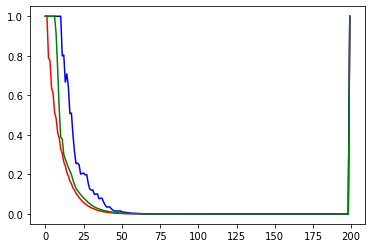

In [28]:
#plot P-values
#plt.subplots(2, len(stratum_gaps))
#very suprising that round robin is better than LSM...
plt.plot(results_rr[0][0], color = 'red')
plt.plot(results_ls[0][0], color = 'blue')
plt.plot(results_ms[0][0], color = 'green')
plt.show()

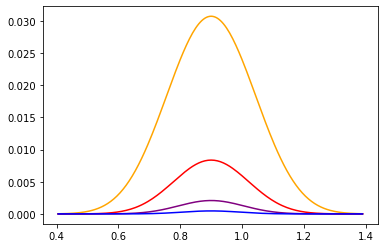

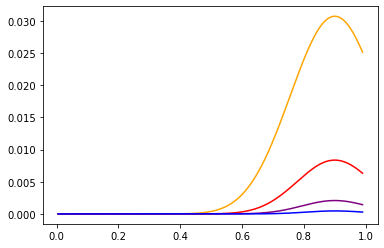

In [35]:
#plot P-values at various sample times as a function of null mean in stratum 1 and the stratum gap...
for i in [0,len(stratum_gaps)-1]:
    plt.plot(results_rr[i][4], 1/np.maximum(1,results_rr[i][3][30,:]), color = 'orange')
    plt.plot(results_rr[i][4], 1/np.maximum(1,results_rr[i][3][40,:]), color = 'red')
    plt.plot(results_rr[i][4], 1/np.maximum(1,results_rr[i][3][50,:]), color = 'purple')
    plt.plot(results_rr[i][4], 1/np.maximum(1,results_rr[i][3][60,:]), color = 'blue')
    plt.show()

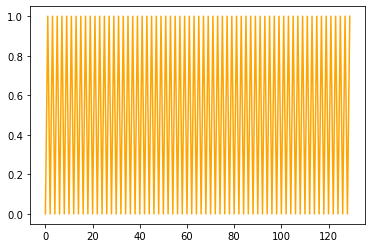

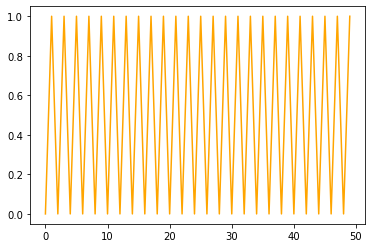

In [9]:
#plot stratum selections at each time for each null mean
for i in [0,len(stratum_gaps)-1]:
    plt.plot(results_rr[i][5][:,50], color = 'orange')
    #plt.plot(results_rr[i][5][:,100], color = 'red')
    #plt.plot(results_rr[i][5][:,150], color = 'purple')
    plt.show()

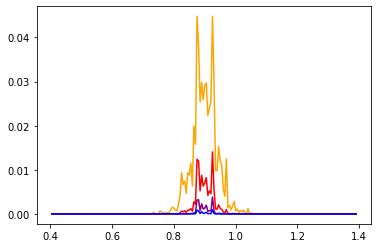

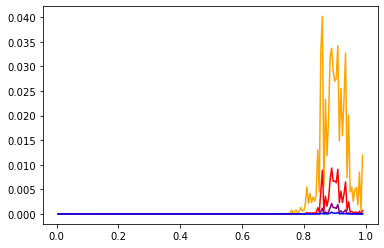

In [36]:
#plot P-values at various sample times as a function of null mean in stratum 1 and the stratum gap...
for i in [0,len(stratum_gaps)-1]:
    plt.plot(results_ms[i][4], 1/np.maximum(1,results_ms[i][3][30,:]), color = 'orange')
    plt.plot(results_ms[i][4], 1/np.maximum(1,results_ms[i][3][40,:]), color = 'red')
    plt.plot(results_ms[i][4], 1/np.maximum(1,results_ms[i][3][50,:]), color = 'purple')
    plt.plot(results_ms[i][4], 1/np.maximum(1,results_ms[i][3][60,:]), color = 'blue')
    plt.show()

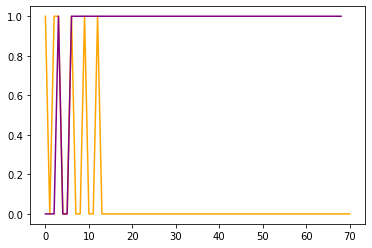

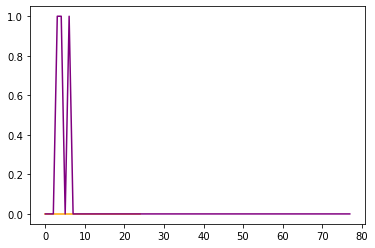

In [11]:
#plot stratum selections at each time for different null means
for i in [0,len(stratum_gaps)-1]:
    plt.plot(results_ms[i][5][:,50], color = 'orange')
    #plt.plot(results_ms[i][5][:,100], color = 'red')
    plt.plot(results_ms[i][5][:,150], color = 'purple')
    plt.show()

In [4]:
stopping_times_roundrobin = simulate_audits(
    strata = strata, 
    u_A = u_A, 
    A_c = A_c, 
    rule = round_robin, 
    n_sims = 30, 
    alpha = .05)
stopping_times_multinomial = simulate_audits(
    strata = strata, 
    u_A = u_A, 
    A_c = A_c, 
    rule = multinomial_selector, 
    n_sims = 30, 
    alpha = .05)

In [5]:
#something seems wrong here...
[np.mean(stopping_times_roundrobin), 
 np.mean(stopping_times_multinomial), 
 np.quantile(stopping_times_roundrobin, q = 0.9),
 np.quantile(stopping_times_multinomial, q = 0.9)]




/Users/Jake/Library/Python/3.8/lib/python/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


[inf, inf, nan, nan]

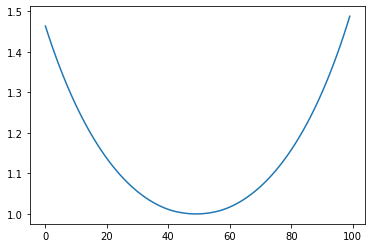

In [46]:
# topography of the P-value of the intersection null at a few sample sizes
#rule = ucb_selector
#rule = multinomial_selector
rule = round_robin

shuffled_1 = np.random.permutation(strata[0])
shuffled_2 = np.random.permutation(strata[1])
N = np.concatenate((np.array([len(shuffled_1)]), np.array([len(shuffled_2)])))
w = N/sum(N)
epsilon = 1 / (2*np.max(N))
raw_theta_1_grid = np.arange(epsilon, u_A[0] - epsilon, epsilon) #sequence from epsilon to u[0] - epsilon
raw_theta_2_grid = (1/2 - w[0] * raw_theta_1_grid) / w[1]
theta_1_grid = raw_theta_1_grid + u_A[0] - A_c[0]
theta_2_grid = raw_theta_2_grid + u_A[1] - A_c[1]

strata_matrix = np.zeros((len(shuffled_1) + len(shuffled_2) - 1, len(theta_1_grid)))
intersection_marts = np.zeros((len(shuffled_1) + len(shuffled_2), len(theta_1_grid)))
for i in range(len(theta_1_grid)):
    mart_1, mu_1 = alpha_mart(x = shuffled_1, N = N[0], mu = theta_1_grid[i], eta = u_A[0], f = .01, u = 2*u_A[0])
    mart_2, mu_2 = alpha_mart(x = shuffled_2, N = N[1], mu = theta_2_grid[i], eta = u_A[1], f = .01, u = 2*u_A[1])
    if rule == ucb_selector:
        lsm_marts_1 = alpha_mart(x = shuffled_1, N = N[0], mu = theta_1_grid[i], eta = theta_1_grid[i]/2, f = .01, u = 2*u_A[0], alternative = "lower")[0]
        lsm_marts_2 = alpha_mart(x = shuffled_2, N = N[1], mu = theta_2_grid[i], eta = theta_2_grid[i]/2, f = .01, u = 2*u_A[1], alternative = "lower")[0]
        lsm_marts = [lsm_marts_1, lsm_marts_2]
    else:
        lsm_marts = None
    strata_matrix[:,i], intersection_marts[:,i] = stratum_selector(
        marts = [mart_1, mart_2],
        mu = [mu_1, mu_2],
        u = 2*u_A,
        lower_sided_marts = lsm_marts,
        rule = rule)
null_index = np.argmin(intersection_marts, axis = 1)
#stratum_selections = strata_matrix[1:sum(N), null_index]
#minimized_martingale = intersection_marts[1:sum(N), null_index]
minimized_martingale = np.ones(sum(N))
stratum_selections = np.ones(sum(N) - 1) * np.inf
for i in np.arange(sum(N) - 1):
    minimized_martingale[i] = intersection_marts[i,null_index[i]]
    stratum_selections[i] = strata_matrix[i,null_index[i]]
maximized_p_values = 1 / np.maximum(1, minimized_martingale)
plt.plot(intersection_marts[10,50:150])

In [50]:
minimized_martingale

array([1.        , 0.64741568, 1.        , 0.89409222, 1.        ,
       0.9228484 , 1.        , 0.93903099, 1.        , 0.94940633,
       1.        , 0.95663315, 1.        , 0.96195257, 1.        ,
       0.96604172, 1.        , 0.9692475 , 1.        , 0.97185689,
       1.        , 0.97400869, 1.        , 0.97585392, 1.        ,
       0.97738633, 1.        , 0.97885593, 1.        , 0.98002939,
       1.        , 0.98115793, 1.        , 0.98200332, 1.        ,
       0.9828701 , 1.        , 0.98362058, 1.        , 0.98419036,
       1.        , 0.98477491, 1.        , 0.98537482, 1.        ,
       0.98587674, 1.        , 0.98621396, 1.        , 0.9865603 ,
       1.        , 0.98691612, 1.        , 0.98728183, 1.        ,
       0.98765784, 1.        , 0.98802555, 1.        , 0.98817479,
       1.        , 0.98832838, 1.        , 0.98848651, 1.        ,
       0.98864939, 1.        , 0.98881724, 1.        , 0.98899027,
       1.        , 0.98916875, 1.        , 0.98935293, 1.     

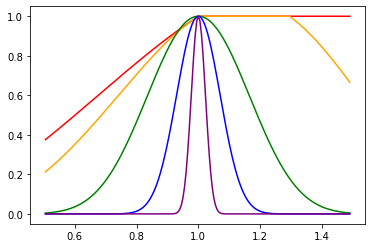

In [52]:
#the below plots are smooth if the rule is round robin, and not at all smooth if it is the intersection martingale
#it might have to do with the fact that different samples are used for every value of theta_1_grid...
#this doesn't happen in the R code: the contours of the intersection martingale are smooth,
#but in that implementation there is no auxiliary randomness
thresholded_marts = intersection_marts
thresholded_marts[intersection_marts < 1] = 1
all_p_values = 1/thresholded_marts
plt.plot(theta_1_grid, all_p_values[1,:], color = 'red')
plt.plot(theta_1_grid, all_p_values[5,:], color = 'orange')
plt.plot(theta_1_grid, all_p_values[30,:], color = 'green')
plt.plot(theta_1_grid, all_p_values[100,:], color = 'blue')
plt.plot(theta_1_grid, all_p_values[180,:], color = 'purple')